In [91]:
from ingestion import make_cleaned, make_train_test
from metadata_helpers import save_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn and its friends
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error


In [99]:
X_train, X_test, y_train, y_test = make_train_test()

categoric_cols = X_train.select_dtypes(include=object).columns.tolist()
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler())
OH_encoder = SklearnTransformerWrapper(transformer=OneHotEncoder(
    sparse_output=False, drop='if_binary', min_frequency=0.1, handle_unknown='ignore'), variables=categoric_cols)
pipe = make_pipeline(std_scaler, OH_encoder, MLPRegressor(
    random_state=42, activation='relu', max_iter=10000, warm_start=True))
learning_rates = [0.008, 0.01]
hidden_layer_sizes = [(177), (120, 60),(100,60,30)]
gs = GridSearchCV(n_jobs=8, estimator=pipe, cv=10,
                  scoring='neg_root_mean_squared_error', param_grid={'mlpregressor__hidden_layer_sizes': hidden_layer_sizes,
                                                                     'mlpregressor__learning_rate_init': learning_rates})


In [100]:
# Took 11 minutes on my machine
gs.fit(X_train, y_train)


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 11, 14, 31] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 23, 32] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sklearntransformerwrapper-1',
                                        SklearnTransformerWrapper(transformer=StandardScaler())),
                                       ('sklearntransformerwrapper-2',
                                        SklearnTransformerWrapper(transformer=OneHotEncoder(drop='if_binary',
                                                                                            handle_unknown='ignore',
                                                                                            min_frequency=0.1,
                                                                                            sparse_output=False),
                                                                  variables=['MSSubClass',
                                                                             'MSZoning',
                                                                             'Street',
                                                                             'Alley',
                                                                             'L...
                                                                             'BsmtFinType2',
                                                                             'Heating',
                                                                             'CentralAir',
                                                                             'Electrical',
                                                                             'Functional',
                                                                             'GarageType',
                                                                             'GarageFinish',
                                                                             'PavedDrive', ...])),
                                       ('mlpregressor',
                                        MLPRegressor(max_iter=10000,
                                                     random_state=42,
                                                     warm_start=True))]),
             n_jobs=8,
             param_grid={'mlpregressor__hidden_layer_sizes': [177, (120, 60),
                                                              (100, 60, 30)],
                         'mlpregressor__learning_rate_init': [0.008, 0.01]},
             scoring='neg_root_mean_squared_error')

In [101]:
gs.best_params_


{'mlpregressor__hidden_layer_sizes': (120, 60),
 'mlpregressor__learning_rate_init': 0.008}

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/

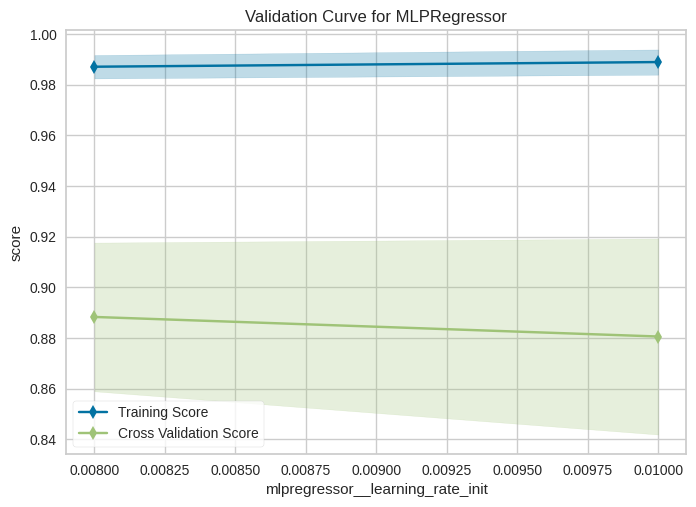

<AxesSubplot: title={'center': 'Validation Curve for MLPRegressor'}, xlabel='mlpregressor__learning_rate_init', ylabel='score'>

In [102]:
pipe_validation = make_pipeline(std_scaler, OH_encoder, MLPRegressor(
    alpha=0.0001, random_state=42, activation='relu', hidden_layer_sizes=(120, 60), max_iter=5000))
viz = ValidationCurve(
    pipe_validation, n_jobs=8, cv=10, param_name='mlpregressor__learning_rate_init', param_range=learning_rates
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


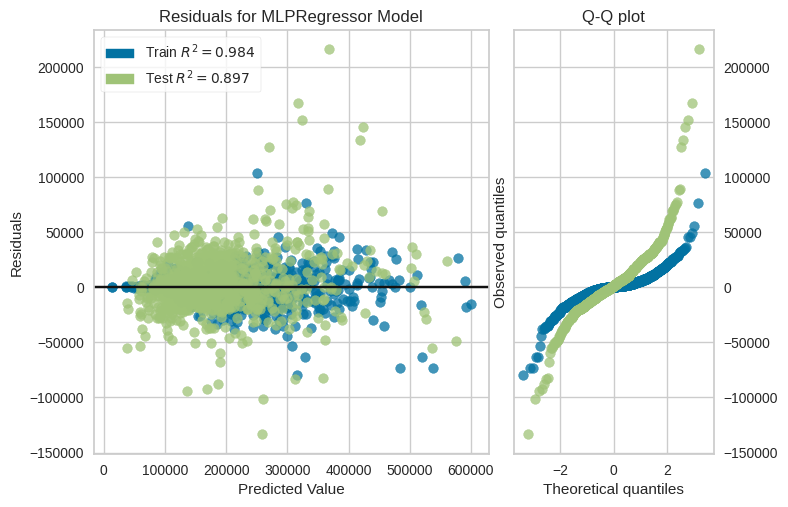

<AxesSubplot: title={'center': 'Residuals for MLPRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [103]:
pipe_final = make_pipeline(std_scaler, OH_encoder, MLPRegressor(
    alpha=0.0001, random_state=42, activation='relu', learning_rate_init=0.008, hidden_layer_sizes=(120, 60), max_iter=15000))
visualizer = ResidualsPlot(pipe_final, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [104]:
rmse_test = mean_squared_error(
    pipe_final.predict(X_test), y_test, squared=False)
print(f"rmse = {rmse_test}")


rmse = 25399.909220530968


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [105]:
save_score(pipe_final, rmse_test)
